# Machine Learning Course Project (Fall 2023)

## Predicting HW grades from ChatGPT interactions

### Collaborators
- Selin Ceydeli
- Barış Tekdemir
- Mert Dursun
- Canberk Tahıl
- Onur Sezen

In [1]:
#!conda activate "c:\Users\mertd\Desktop\Dersler\CS 412\.conda"
!python --version
#!pip install matplotlib
#!pip install pandas
#!pip install graphviz
#!pip install bs4
#!pip install scikit-learn
#!pip install torch
#!pip install torch transformers

Python 3.10.12


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bac12e1d-3a8c-5fa9-06a8-d28f0a6a5b74)


### Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [4]:
# Importing the necessary libraries
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## Download Conversation Data

This Python code cell is part of a script that processes HTML files to extract conversation data. It uses Beautiful Soup to parse the HTML and extract div elements that match a specific pattern indicative of conversation turns. It then captures the text and author role of each conversation snippet and stores them in a dictionary with the file's base name (minus the extension) as the key, effectively mapping file codes to conversation texts.

In [5]:
data_path = "/content/drive/MyDrive/Project Data/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [01:12<00:00,  1.75it/s]


The code snippet shown in the image is a Python command that uses the pprint function to print out the first conversation item from the dictionary code2convos with the key "0031c86e-81f4-4eef-9e0e-28037abf9883". This indicates that each conversation has been stored as a list of dictionaries under each file code, and the snippet aims to display the conversation in a readable format.

In [6]:
# Let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


# BERT _____________________________________________

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorc

Minimum Current Seen Loss:  0.008893354535102845


Minimum Current Seen Loss:  0.002573404312133789


Minimum Current Seen Loss:  2.6892346795648336e-05


Minimum Current Seen Loss:  2.6892346795648336e-05


Minimum Current Seen Loss:  8.820394286885858e-06


Minimum Current Seen Loss:  8.820394286885858e-06


Minimum Current Seen Loss:  8.820394286885858e-06


Minimum Current Seen Loss:  8.820394286885858e-06


Minimum Current Seen Loss:  8.820394286885858e-06


Minimum Current Seen Loss:  8.820394286885858e-06


Minimum Current Seen Loss:  8.820394286885858e-06


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Minimum Current Seen Loss:  2.582562592579052e-07


Mean Squared Error on Validation Set: 313.7881362723549


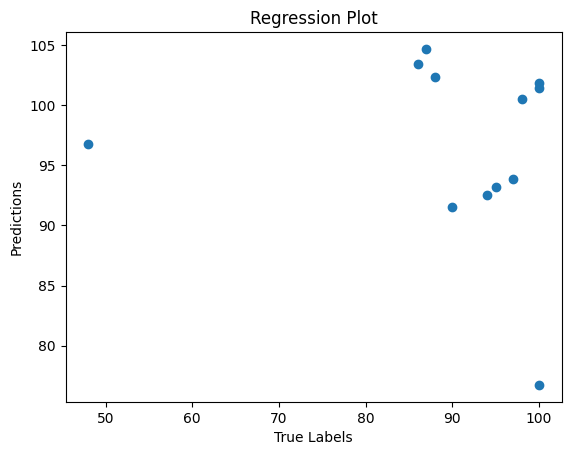

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_bar  # Rename tqdm to avoid conflict

# Step 1: Import Pretrained Large Bert Model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 2: Split the data
# Assuming you have a list of tuples (text, score) as your data
# Replace this with your actual data loading process


# Load scores and preprocess
scores = pd.read_csv("/content/drive/MyDrive/Project Data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())
scores = scores[["code", "grade"]]

data = []

# Getting ChatGPT replies
for chatgpt_url, turns in code2convos.items():
    text = ""
    for turn in turns:
        if turn["role"] == "assistant":
            # print(turn)
            response = turn["text"]
            text += (response + " ")

    # Use .loc to get the grade for the specific code
    matched_grade = scores.loc[scores['code'] == chatgpt_url, 'grade'].values

    if len(text) > 0 and len(matched_grade) != 0 and matched_grade[0] >= 0:
        if len(matched_grade) > 1:
            matched_grade = matched_grade[0]
        data.append((text, matched_grade))


# data = [("Example text 1", 75), ("Example text 2", 90), ...]

# texts, scores = zip(*data)

# Using list comprehension to split the tuples into two lists
texts = [item[0] for item in data]
scores = [item[1] for item in data]

# Split data into training, validation, and test sets (80-10-10 split)
texts_train, texts_temp, scores_train, scores_temp = train_test_split(texts, scores, test_size=0.2, random_state=42)
texts_val, texts_test, scores_val, scores_test = train_test_split(texts_temp, scores_temp, test_size=0.5, random_state=42)

# Step 3: Finetune the model
class TextDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, max_len=512):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        score = float(self.scores[idx]) / 100.0 # Scale labels to [0, 1]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(score).unsqueeze(0)}

train_dataset = TextDataset(texts_train, scores_train, tokenizer)
val_dataset = TextDataset(texts_val, scores_val, tokenizer)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

# Training parameters
epochs = 100
lr = 1e-5

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=lr)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = torch.nn.MSELoss()

min_loss = float('inf')

# Training loop with tqdm
for epoch in range(epochs):
    model.train()
    tqdm_loader = tqdm_bar(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
    for batch in tqdm_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss * 100  # Adjust the loss calculation

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        tqdm_loader.set_postfix({'loss': loss.item() / 100})  # Display the loss in the original scale
        if (loss.item() / 100) < min_loss:
          min_loss = (loss.item() / 100)

    if epoch % 5 == 0:
        print("Minimum Current Seen Loss: ", str(min_loss))

# Step 4: Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    tqdm_loader = tqdm_bar(val_loader, desc='Evaluating', leave=False)
    for batch in tqdm_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy())

# Scale test set labels back to the original range [0, 100]
true_labels = [label * 100 for label in true_labels]
predictions = [prediction * 100 for prediction in predictions]

# Calculate mean squared error
mse = mean_squared_error(true_labels, predictions)
print(f'Mean Squared Error on Validation Set: {mse}')

# Plot regression plot
plt.scatter(true_labels, predictions)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Regression Plot')
plt.show()

Mean Squared Error on Validation Set: 287.20384665951775


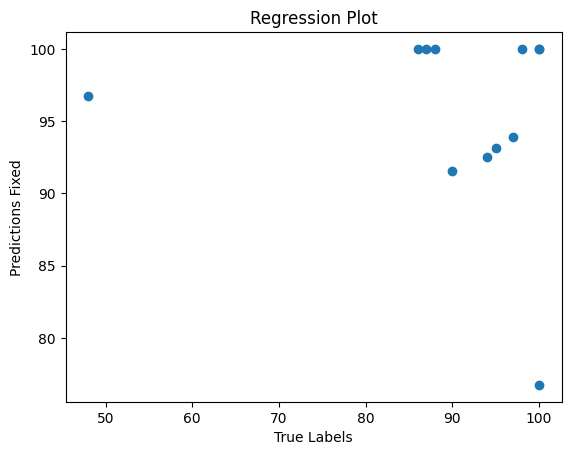

In [8]:
predictions_fixed = []
for item in predictions:
  if item > 100:
    predictions_fixed.append(100)
  else:
    predictions_fixed.append(item)

# Calculate mean squared error
mse = mean_squared_error(true_labels, predictions_fixed)
print(f'Mean Squared Error on Validation Set: {mse}')

# Plot regression plot
plt.scatter(true_labels, predictions_fixed)
plt.xlabel('True Labels')
plt.ylabel('Predictions Fixed')
plt.title('Regression Plot')
plt.show()

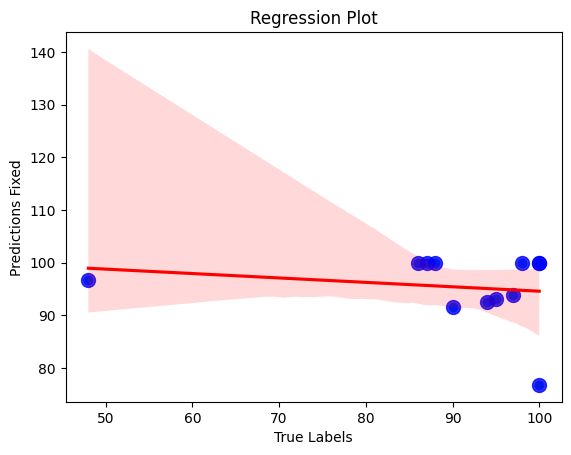

In [11]:
import seaborn as sns
# Plot regression plot
plt.scatter(true_labels, predictions_fixed)
sns.regplot(x=true_labels, y=predictions_fixed, scatter_kws={'s': 100, 'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('True Labels')
plt.ylabel('Predictions Fixed')
plt.title('Regression Plot')
plt.show()

# Project Overview

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

## Prompt Matching
> We want to match the prompts with the questions in the Homework. Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distances to do the matching.

The code collects all text entries from conversations where the role is "user" and groups them by their respective conversation code, storing the result in a dictionary.

In [ ]:
prompts = []
code2prompts = defaultdict(list)

for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

Display the first user prompt from the prompts list.

In [ ]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

We create a dictionary of questions.

In [ ]:
# Creating a dictionary out of the homework questions
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

The code initializes a TfidfVectorizer, which is a tool to convert a collection of raw documents to a matrix of TF-IDF features. It then fits the vectorizer to the combined list of prompts and questions, which trains the vectorizer on the text data so it can transform this text into numerical data suitable for machine learning algorithms.

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

The code takes the questions data, transforms it into a TF-IDF representation using the previously fitted vectorizer, and then creates a Pandas DataFrame from this transformed data. The columns of the DataFrame are named after the features generated by the vectorizer.

In [ ]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The code iterates over the code2prompts dictionary, which holds user prompts grouped by some code. For each group, if there are prompts present, it vectorizes these prompts using the TF-IDF vectorizer and stores the resulting TF-IDF features as a DataFrame in a new dictionary code2prompts_tf_idf, keyed by the same codes. If a group of prompts is empty, it prints the code with ".html" appended, indicating a potential issue with the corresponding HTML file, and continues to the next iteration.

In [ ]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # Some html files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


The code is attempting to display the first few entries of the TF-IDF feature representation for the user prompts corresponding to the specific code "089eb66d-4c3a-4f58-b98f-a3774a2efb34" from the code2prompts_tf_idf dictionary.

In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The code is using the .shape attribute to determine the dimensions of the DataFrame. This will return a tuple representing the number of rows and columns in that DataFrame.

In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

The code snippet is iterating through the code2prompts_tf_idf dictionary to calculate the cosine similarity between the TF-IDF vectors of the user prompts and some other set of TF-IDF vectors named questions_TF_IDF. For each code, it creates a Pandas DataFrame that contains the cosine similarity scores and stores these data frames in a new dictionary called code2cosine, indexed by the same codes.

In [ ]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [ ]:
questions[8]

'Find the information gain on the first split (10 pts)'

The code processes the cosine similarity scores for each code from the code2cosine dictionary, extracting the maximum similarity score across each row (which likely corresponds to the most similar question for each user prompt). These maximum scores are stored in a new dictionary code2questionmapping. Then, it creates a DataFrame from this dictionary, transposes it, resets the index, and renames the columns to correspond to question indices and codes. Finally, it prepares to display the question_mapping_scores DataFrame.

In [ ]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


## Part 1: Feature Engineering
- Number of prompts that a user asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts' average number of characters


In this code block, we process conversation data stored in the code2convos dictionary, extracting and analyzing various features related to user prompts and ChatGPT responses. We initialize a defaultdict, code2features, to store the computed statistics for each code, representing different files. We define a set of keywords to search for in user prompts, convert them to lowercase for case-insensitive matching, and iterate through each code and its associated conversations. For each conversation, we extract features such as the total number of user prompts, occurrences of specified keywords, and the average character length of both user prompts and ChatGPT responses. The resulting statistics are stored in the **code2features** dictionary, providing insights into the usage patterns, keyword occurrences, and length characteristics of user prompts and ChatGPT responses for each code.

In [ ]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In the below code, we use Pandas to convert the code2features dictionary into a transposed DataFrame (df). The subsequent display of the first five rows with df.head(5) provides a concise overview of computed statistics, including user prompt counts, keyword occurrences, and average character lengths for each code.

In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In the code belown, we read scores from a CSV file by utilizing the **pd.read_csv** function, with the file path **"./scores.csv"** and a specified separator ("," in this case). The data preprocessing involves stripping whitespaces from the **"code"** column and selecting the columns **"code"** and **"grade"**. The resulting DataFrame, displayed with **scores.head()**, showcases the processed scores data, emphasizing the codes and corresponding grades.

In [ ]:
# reading the scores
scores = pd.read_csv("/content/drive/MyDrive/Project Data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0



In this section, we analyzed the distribution of grades from the **"grade"** column in the scores DataFrame. We created a histogram to visualize the count of grades, offering a clear representation of their distribution and aiding our understanding of the overall grade distribution.

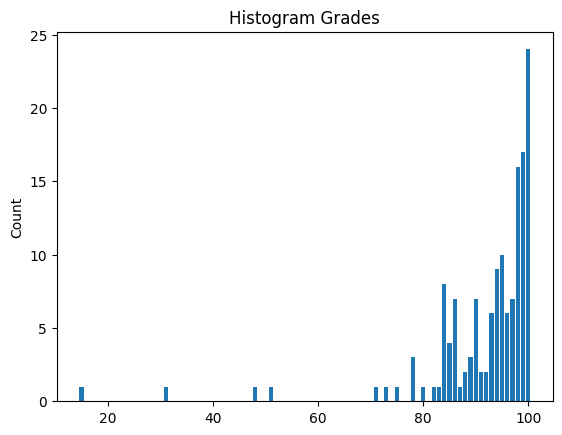

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()


In this portion, we restructure the **df** by resetting its index and renaming the **"index"** column to **"code"**, recognizing the fact that each code is unique.

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In this step, we merged the DataFrame df with **question_mapping_scores** based on the **"code"** column, using a left join. The resulting DataFrame, displayed through **df.head()**, showcases the combined data for further analysis that we will do.

In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


#### Merging scores with features

In the code block below, we combine the DataFrame df with the scores DataFrame using a left join on the **"code"** column, creating the DataFrame **temp_df**. We then remove rows with missing values and eliminate duplicate entries based on the **"code"** column. The resulting **temp_df** is displayed to offer an initial view of the refined dataset.

In [ ]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


## Part 2: Data Splitting with Stratification

The code in the image is preparing data for machine learning by splitting a Pandas DataFrame temp_df into features and target variables. The X variable is assigned all columns except the last one (presumed to be the features), and the y variable is assigned the last column, named "grade". It then converts both to NumPy arrays and prints out their shapes to confirm the dimensions, which would typically show the number of samples and features for X, and the number of samples for y.

In [ ]:
# Using the temp_df data frame to find the X and y columns
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 17) (122,)


The code snippet identifies rare classes in the target variable y of a machine learning dataset. It does this by converting y to a Pandas Series, then using value_counts() to count the occurrences of each class. It sets a threshold of 1 to identify classes that have 1 or fewer occurrences (which are too few for stratification in train/test splitting). It then lists these rare classes and prints their counts. The comment indicates that for stratification purposes, each class should have at least two members.

In [ ]:
# The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2 to apply stratification.
# Identify which classes in the target variable y are rare
y_series = pd.Series(y)
class_counts = y_series.value_counts()
threshold = 1
rare_classes = class_counts[class_counts <= threshold].index
print("There are", len(rare_classes), "rare classes.")
print("Rare classes:", rare_classes)

There are 11 rare classes.
Rare classes: Float64Index([51.0, 82.0, 73.0, 48.0, 75.0, 31.0, 71.0, 87.0, 83.0, 80.0,
              15.0],
             dtype='float64')


The code constructs a mapping for rare classes in the dataset to their corresponding feature vectors from X. It creates an empty dictionary rare_class_mapping, then iterates over the target variable y. For each label that is a rare class, it adds an entry to the dictionary with the feature vector X[i] (converted to a tuple to be hashable) as the key and the label as the value. Finally, it prints the first five entries of this mapping to show the feature vectors associated with the rare classes. This could be useful for further analysis or handling of rare classes in machine learning.

In [ ]:
# Creating a dictionary to map each rare class with its corresponding x values
rare_class_mapping = {}

# Iterate over the dataset to fill the mapping dictionary
for i, label in enumerate(y):
    if label in rare_classes:
        # Using tuple to represent X values since X is multi-dimensional
        rare_class_mapping[tuple(X[i])] = label

# Print the rare class mapping
print("Rare class mapping (showing first 5 entries):")
for i, (x_val, y_val) in enumerate(rare_class_mapping.items()):
    if i < 5:  # Limiting to first 5 entries for brevity
        print(f"X: {x_val}, Y: {y_val}")

Rare class mapping (showing first 5 entries):
X: (14.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.2057484646025123, 212.2063696746579, 0.15354089378499097, 0.2948791719118865, 0.5221693252600499, 0.35224306559042085, 0.4606063455402358, 0.5538756543429254, 0.16725042992671718, 0.18293808775235298, 0.19543980723403126), Y: 48.0
X: (11.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.37920580282402194, 75.60496195016243, 0.14097737255739948, 0.09199930347659896, 0.21102167544575706, 0.1400835796677126, 0.13801198122777156, 0.14189850129255804, 0.16621067310540696, 0.14588250160800748, 0.17782382740141842), Y: 80.0
X: (17.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.3028881801900086, 45.07373871576399, 0.15007116338592585, 0.1545910946787663, 0.3872598150372279, 0.3001939877162661, 0.6787967224514032, 0.9567268587629829, 0.8711550838313178, 0.3160171676560152, 0.1273575986449008), Y: 83.0
X: (16.0, 2.0, 0.0, 0.0, 1.0, 3.0, 0.01821910780914412, 180.69763116556317, 0.18231165518678058, 0.21240031109099505, 0.9717752469707128, 0.8482763653

The code snippet is for handling rare classes in a dataset to facilitate stratified splitting. It first sorts the rare classes by their frequency in ascending order. Then, it pairs up the classes and assigns a new group label to each pair to ensure that no group has a single member (which is necessary for stratification). If there's an odd number of classes, the last class is grouped with the last pair. A mapping of the new group labels to the original classes is stored, and the target variable y is updated with these new grouped labels. Finally, the code prints the head of the new grouped target variable and the mapping of group labels to original class values.

In [ ]:
# Pair rare classes to apply stratification while splitting data

# Sort rare classes in increasing order of their frequency
sorted_rare_classes = rare_classes.sort_values(ascending=True)

# Pair them up and create a new label for each pair, ensuring no single-value group at the end
grouped_labels = {}
original_values = {}  # To store original values for each group
for i in range(0, len(sorted_rare_classes), 2):
    # If this is the last pair and there's an odd number of classes, include the last class in the previous group
    if i == len(sorted_rare_classes) - 1 and len(sorted_rare_classes) % 2 != 0:
        pair = sorted_rare_classes[i-1:i+1]
        new_label = f"group_{(i-1)//2}"
    else:
        pair = sorted_rare_classes[i:i+2]
        new_label = f"group_{i//2}"
    for cls in pair:
        grouped_labels[cls] = new_label
        original_values.setdefault(new_label, []).append(cls)

# Replace rare classes with their new grouped labels in the target variable
y_grouped = y_series.replace(grouped_labels)

# Print the first few rows of the new target variable
print(y_grouped.head())

# Print the mapping of groups to their original class values
print("Original values for each group:", original_values)

0    group_1
1       99.0
2       90.0
3       97.0
4      100.0
dtype: object
Original values for each group: {'group_0': [15.0, 31.0], 'group_1': [48.0, 51.0], 'group_2': [71.0, 73.0], 'group_3': [75.0, 80.0], 'group_4': [82.0, 83.0, 83.0, 87.0]}


The code updates the rare_class_mapping dictionary to include both the original class label (y value) and the new group label created for stratification purposes. It iterates over the feature vectors (X values) and checks if the corresponding original class label is in the grouped_labels dictionary. If so, it retrieves the new group label and updates the mapping with both the original and new labels. Then, it prints the first five entries of this updated mapping, showing each feature vector's original class label and its new group label. This could be used to track changes and ensure that the grouping is done correctly before proceeding with stratified sampling or other analysis.

In [ ]:
# Update the rare_class_mapping to include both original y value and new group label
for x_val in rare_class_mapping.keys():
    original_y_val = rare_class_mapping[x_val]
    if original_y_val in grouped_labels:
        group_label = grouped_labels[original_y_val]
        # Store both the original y value and the new group label
        rare_class_mapping[x_val] = {'original_y': original_y_val, 'group_label': group_label}

# Print the updated rare class mapping (showing first 5 entries for brevity)
print("Updated rare class mapping with both values and labels (showing first 5 entries):")
for i, (x_val, mapping_info) in enumerate(rare_class_mapping.items()):
    if i < 5:
        print(f"X: {x_val}, Original Y: {mapping_info['original_y']}, Group Label: {mapping_info['group_label']}")

Updated rare class mapping with both values and labels (showing first 5 entries):
X: (14.0, 3.0, 1.0, 0.0, 0.0, 0.0, 2.2057484646025123, 212.2063696746579, 0.15354089378499097, 0.2948791719118865, 0.5221693252600499, 0.35224306559042085, 0.4606063455402358, 0.5538756543429254, 0.16725042992671718, 0.18293808775235298, 0.19543980723403126), Original Y: 48.0, Group Label: group_1
X: (11.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.37920580282402194, 75.60496195016243, 0.14097737255739948, 0.09199930347659896, 0.21102167544575706, 0.1400835796677126, 0.13801198122777156, 0.14189850129255804, 0.16621067310540696, 0.14588250160800748, 0.17782382740141842), Original Y: 80.0, Group Label: group_3
X: (17.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.3028881801900086, 45.07373871576399, 0.15007116338592585, 0.1545910946787663, 0.3872598150372279, 0.3001939877162661, 0.6787967224514032, 0.9567268587629829, 0.8711550838313178, 0.3160171676560152, 0.1273575986449008), Original Y: 83.0, Group Label: group_4
X: (16.0, 2.0, 0.0, 0

The code checks for the presence of rare classes within the grouped target variable y_grouped. It converts y_grouped into a Pandas Series, calculates the frequency of each class, and then identifies any classes that occur at or below the threshold of 1, which would be considered rare. Finally, it prints out the number of these rare classes. This is likely done to verify the success of the grouping operation and to ensure that there are no classes with too few samples for stratified sampling.

In [ ]:
# Check if there are any more rare classes after grouping
y_series = pd.Series(y_grouped)
class_counts = y_series.value_counts()
threshold = 1
rare_classes = class_counts[class_counts <= threshold].index
print("There are", len(rare_classes), "rare classes.")

There are 0 rare classes.


The code performs a stratified train-test split on the dataset. It converts the y_grouped Pandas Series (which contains the grouped target variable) into a NumPy array of strings. The train_test_split function is then used to split the features X and the target y_grouped_array into training and test sets, with the test set size being 20% of the dataset and stratification enabled to maintain the proportion of classes. A random state is set for reproducibility. Finally, it prints out the sizes of the training and test sets and a sample of 20 elements from both y_train and y_test to verify the split.

In [ ]:
# Now, perform data splitting
# Convert y_grouped from a pandas Series to a numpy array and ensure all elements are strings
y_grouped_array = y_grouped.astype(str).to_numpy()

# Since the data is imbalanced with respect to student grades, apply train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y_grouped_array, test_size=0.2, random_state=42, stratify=y_grouped_array)

# Print the sizes of the train and test sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

print("Sample of y_train:", y_train[:20])
print("Sample of y_test:", y_test[:20])

Train set size: 97
Test set size: 25
Sample of y_train: ['93.0' '94.0' '99.0' '95.0' 'group_2' '78.0' '100.0' '78.0' '100.0'
 '100.0' '99.0' '85.0' '97.0' '97.0' '84.0' '88.0' 'group_1' '98.0' '98.0'
 '98.0']
Sample of y_test: ['95.0' '90.0' '100.0' '94.0' '99.0' '89.0' '94.0' '97.0' '99.0' '84.0'
 '99.0' '98.0' '95.0' '90.0' '100.0' '86.0' '97.0' '100.0' 'group_4'
 '100.0']


The code reverses the grouping of target variables applied for stratification back to their original labels after a train-test split. It converts y_train and y_test back to Pandas Series for easier manipulation. It then iterates over the rare_class_mapping to find the indices in X_train and X_test that match the feature vectors (x_val) associated with the rare classes. Once these indices are found, it replaces the group labels in y_train and y_test with the original class labels. After the replacement, y_train and y_test are converted back into NumPy arrays. Finally, it prints the sizes of the train and test sets and samples of the reverted y_train and y_test values to verify the changes.

In [ ]:
# Replace the group labels in y_train and y_test with their original values

# Convert y_train and y_test back to pandas Series for easier manipulation
# Use the range of the length of y_train and y_test as index
y_train_series = pd.Series(y_train, index=range(len(y_train)))
y_test_series = pd.Series(y_test, index=range(len(y_test)))

# Iterate over the rare_class_mapping to replace group labels with original y values
for x_val, mapping_info in rare_class_mapping.items():
    original_y = mapping_info['original_y']
    group_label = mapping_info['group_label']

    # Check if the x_val matches in either X_train or X_test
    # Compare using the indices from y_train_series and y_test_series
    matching_train_indices = [index for index, row in enumerate(X_train) if np.array_equal(row, x_val)]
    matching_test_indices = [index for index, row in enumerate(X_test) if np.array_equal(row, x_val)]

    # Replace group label with original y value where the x_values match
    for index in matching_train_indices:
        if y_train_series.at[index] == group_label:
            y_train_series.at[index] = original_y
    for index in matching_test_indices:
        if y_test_series.at[index] == group_label:
            y_test_series.at[index] = original_y

# Convert the Series back to numpy arrays
y_train = y_train_series.to_numpy()
y_test = y_test_series.to_numpy()

# Print the sizes of the train and test sets and a few samples
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
print("Sample of y_train:", y_train[:20])
print("Sample of y_test:", y_test[:20])

Train set size: 97
Test set size: 25
Sample of y_train: ['93.0' '94.0' '99.0' '95.0' 73.0 '78.0' '100.0' '78.0' '100.0' '100.0'
 '99.0' '85.0' '97.0' '97.0' '84.0' '88.0' 48.0 '98.0' '98.0' '98.0']
Sample of y_test: ['95.0' '90.0' '100.0' '94.0' '99.0' '89.0' '94.0' '97.0' '99.0' '84.0'
 '99.0' '98.0' '95.0' '90.0' '100.0' '86.0' '97.0' '100.0' 83.0 '100.0']


### Creating a temp_df Data Frame Using the Training Sets to be Used in Clustering

The code snippet converts the training feature set X_train and the training target variable y_train into separate Pandas DataFrames. Then, it concatenates these two DataFrames along the columns (axis=1) to create a single DataFrame temp_df that contains both the features and the target variable. Lastly, it displays the first five rows of temp_df using the head() method to provide a preview of the combined data.

In [ ]:
x_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)

# Concatenating x_train_df and y_train_df into a DataFrame
temp_df = pd.concat([x_train_df, y_train_df], axis=1)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,0
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.170750,1.000000,0.864877,1.000000,0.942662,0.606780,1.000000,1.000000,0.717228,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.192013,0.795607,1.000000,0.950344,0.957975,0.947105,1.000000,0.893185,0.739056,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.155710,0.202340,0.556567,0.760269,0.791184,0.854994,0.697354,0.873438,0.506600,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.192013,0.795607,1.000000,0.831596,0.942662,1.000000,1.000000,0.862585,0.548097,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.049583,0.107727,0.197931,0.148757,0.572173,0.174753,0.221895,0.135906,0.234228,73.0


The code snippet is designed to finalize the structure of the temp_df DataFrame. It starts with a predefined list of column names that includes features such as user prompts, various keywords, average characters per prompt/response, question labels, and the target variable "grade". The code then adds additional columns with NaN (Not a Number) values to the temp_df DataFrame if the current number of columns is less than the number of predefined column names. This ensures that the DataFrame has the correct number of columns as specified in column_names. After adding any necessary columns, it assigns the column_names list as the header for temp_df. Finally, it retrieves the shape of temp_df, which provides the dimensions (number of rows and columns) of the DataFrame.

In [ ]:
column_names = ["#user_prompts", "#error", "#no", "#thank", "#next", "#entropy",
                "prompt_avg_chars", "response_avg_chars", "Q_0", "Q_1", "Q_2", "Q_3",
                "Q_4", "Q_5", "Q_6", "Q_7", "Q_8", "grade"]

# Adding additional columns with NaN values to match the length of column_names
for col in column_names[len(temp_df.columns):]:
    temp_df[col] = np.nan

# Assigning the column names
temp_df.columns = column_names

temp_df.shape

(97, 18)

In [ ]:
temp_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.170750,1.000000,0.864877,1.000000,0.942662,0.606780,1.000000,1.000000,0.717228,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.192013,0.795607,1.000000,0.950344,0.957975,0.947105,1.000000,0.893185,0.739056,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.155710,0.202340,0.556567,0.760269,0.791184,0.854994,0.697354,0.873438,0.506600,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.192013,0.795607,1.000000,0.831596,0.942662,1.000000,1.000000,0.862585,0.548097,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.049583,0.107727,0.197931,0.148757,0.572173,0.174753,0.221895,0.135906,0.234228,73.0


### Creating a testing_df Data Frame Using the Testing Sets to be Used in Performance Testing of the NN Model

In [ ]:
x_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

# Concatenating x_train_df and y_train_df into a DataFrame
testing_df = pd.concat([x_test_df, y_test_df], axis=1)
testing_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,0
0,44.0,1.0,3.0,0.0,0.0,2.0,0.022834,21.417939,0.230257,0.680878,0.931647,1.000000,0.942662,0.791696,1.000000,1.000000,0.810325,95.0
1,10.0,0.0,0.0,0.0,0.0,3.0,0.079311,14.685285,0.146835,0.368985,0.369341,0.241597,0.607114,0.297453,0.353324,0.143109,0.543064,90.0
2,42.0,3.0,0.0,0.0,1.0,3.0,1.184860,42.410799,0.203694,0.311241,0.738960,0.656635,0.597213,0.485064,0.478191,0.323608,0.518084,100.0
3,52.0,4.0,1.0,0.0,0.0,9.0,0.017075,61.801989,0.145812,0.179212,0.637515,0.950344,0.724872,0.987511,0.652334,0.633609,0.523410,94.0
4,37.0,8.0,2.0,0.0,0.0,3.0,0.184312,46.940561,0.225840,0.864976,1.000000,0.754698,1.000000,0.816583,1.000000,1.000000,0.739056,99.0


In [ ]:
column_names = ["#user_prompts", "#error", "#no", "#thank", "#next", "#entropy",
                "prompt_avg_chars", "response_avg_chars", "Q_0", "Q_1", "Q_2", "Q_3",
                "Q_4", "Q_5", "Q_6", "Q_7", "Q_8", "grade"]

# Adding additional columns with NaN values to match the length of column_names
for col in column_names[len(testing_df.columns):]:
    testing_df[col] = np.nan

# Assigning the column names
testing_df.columns = column_names

testing_df.shape

(25, 18)

In [ ]:
testing_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,44.0,1.0,3.0,0.0,0.0,2.0,0.022834,21.417939,0.230257,0.680878,0.931647,1.000000,0.942662,0.791696,1.000000,1.000000,0.810325,95.0
1,10.0,0.0,0.0,0.0,0.0,3.0,0.079311,14.685285,0.146835,0.368985,0.369341,0.241597,0.607114,0.297453,0.353324,0.143109,0.543064,90.0
2,42.0,3.0,0.0,0.0,1.0,3.0,1.184860,42.410799,0.203694,0.311241,0.738960,0.656635,0.597213,0.485064,0.478191,0.323608,0.518084,100.0
3,52.0,4.0,1.0,0.0,0.0,9.0,0.017075,61.801989,0.145812,0.179212,0.637515,0.950344,0.724872,0.987511,0.652334,0.633609,0.523410,94.0
4,37.0,8.0,2.0,0.0,0.0,3.0,0.184312,46.940561,0.225840,0.864976,1.000000,0.754698,1.000000,0.816583,1.000000,1.000000,0.739056,99.0


## Part 3: Estimating Points Received Per Question by Clustering
- Apply a clustering algorithm to find clusters.
- Loop over the question columns and perform clustering on each one.
- After clustering, each student's response for a question is assigned a cluster label.
- The central value (mean) of each cluster (e.g. cluster center) is used to represent the typical score within that cluster for each question.
- A 'calculated_total_grade' column is generated by summing up the points students received per question.

In [ ]:
# Before making any modifications on the temp_df data frame, make a copy of it to later on apply Gaussian Mixture Model
temp_df2 = temp_df.copy()

### Clustering with K-Means Algorithm
- Clustering is applied on the training dataframe.
- Then, using the cluster centers learned on the training dataframe, testing dataframe is also clustered to be later on used for performance evaluation of the Neural Network model.

The code assigns different weights to similarity scores based on the importance of each question, which are defined in the question_points list. It then normalizes these scores by multiplying each question's score by its corresponding weight if that question's column exists in the temp_df DataFrame. After normalizing the scores, the KMeans clustering algorithm will be applied to the data to form clusters based on these weighted scores. The number of clusters num_clusters is set to 9, presumably corresponding to the number of different categories or types of responses available in the dataset. The temp_df.head() function call at the end is used to display the first few rows of the DataFrame after the normalization step.

In [ ]:
# Define the maximum points for each question, adjust this if your data has fewer questions
question_points = [0, 5, 15, 5, 10, 20, 15, 20, 10]

# Normalize the similarity scores to the range of points available for each question
for i in range(len(question_points)):
    # Ensure the column exists before trying to access it
    if f'Q_{i}' in temp_df.columns:
        temp_df[f'Q_{i}'] = temp_df[f'Q_{i}'] * question_points[i]

# Now, we'll use the normalized scores to cluster the data.
# We will use the KMeans algorithm to form clusters based on these scores.
# The number of clusters is set to the number of questions you have data for
num_clusters = 9

temp_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.0,5.000000,12.973160,5.000000,9.426619,12.135597,15.000000,20.000000,7.172280,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.0,3.978035,15.000000,4.751721,9.579752,18.942105,15.000000,17.863693,7.390557,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.0,1.011699,8.348507,3.801345,7.911845,17.099882,10.460315,17.468752,5.065995,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.0,3.978035,15.000000,4.157980,9.426619,20.000000,15.000000,17.251694,5.480967,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.0,0.538633,2.968960,0.743784,5.721731,3.495069,3.328430,2.718113,2.342283,73.0


The code performs KMeans clustering for each question column in the temp_df DataFrame. It loops through each question column and, if the column exists, applies the KMeans algorithm to the data in that column, using the predefined number of clusters (num_clusters). The cluster labels are then added to temp_df as a new column for each question. Additionally, it maps each cluster label to the corresponding cluster center, adding this as another column to temp_df. This process assigns a point value to each cluster, likely representing the strength or relevance of the responses to that question. Finally, it displays the first few rows of temp_df to verify the results of the clustering.

In [ ]:
# Loop over the question columns and perform clustering on each one
for i in range(len([col for col in temp_df.columns if col.startswith('Q_')])):
    # Check if the question column exists
    if f'Q_{i}' in temp_df.columns:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(temp_df[[f'Q_{i}']])

        # Add the cluster labels to temp_df
        temp_df[f'Q_{i}_cluster'] = kmeans.labels_

        # Map each cluster label to the corresponding cluster center and add to temp_df
        cluster_centers = kmeans.cluster_centers_.squeeze()
        temp_df[f'Q_{i}_point_received'] = temp_df[f'Q_{i}_cluster'].map(lambda x: int(cluster_centers[x]))

# Outputting the first few rows of 'temp_df' to verify the clustering results
temp_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-49-58317f1e32c0>:7: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  kmeans.fit(temp_df[[f'Q_{i}']])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value o

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_4_cluster,Q_4_point_received,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.0,5.000000,...,6,9,3,11,5,14,6,19,2,7
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.0,3.978035,...,6,9,4,19,5,14,0,17,2,7
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.0,1.011699,...,4,7,1,16,8,10,0,17,0,4
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.0,3.978035,...,6,9,4,19,5,14,0,17,7,5
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.0,0.538633,...,0,5,0,2,0,2,5,3,1,2


The code snippet imports necessary libraries and sets up for KMeans clustering by defining the maximum points for each question. It then loops through the data, applying the KMeans algorithm to each question column within the temp_df DataFrame, and assigns the resulting cluster labels back to the DataFrame.

After clustering, it retrieves the cluster centers and plots the clusters. For each question's clustering, it creates a scatter plot visualizing the data points with their cluster assignments and the cluster centers. The plt.scatter function is used twice: first to plot the data points, using the DataFrame index as the x-axis and the question column values as the y-axis, and second to plot the cluster centers.

The plot is customized with a specific figure size, colormap (cmap='viridis' for data points and red color for cluster centers), and markers. It includes a title indicating which question's clustering is visualized, labels for the x and y-axis, and a legend. Finally, plt.show() is called to display the plot. This visualization can help in understanding the distribution of data points and the location of cluster centers in the feature space.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


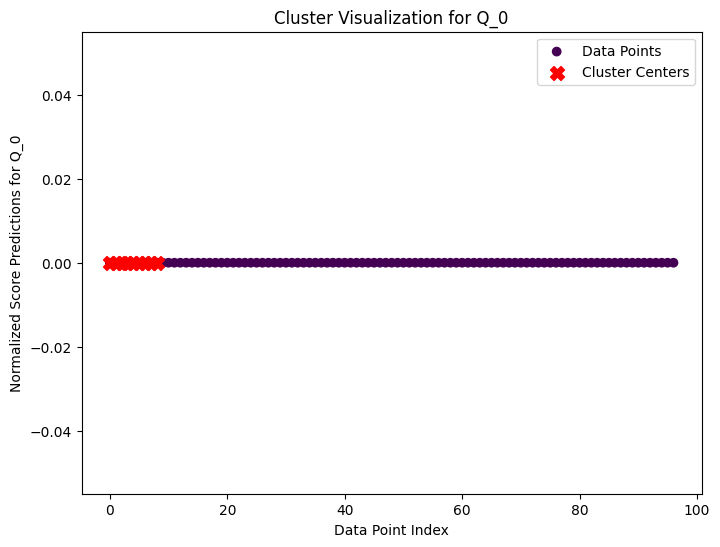

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


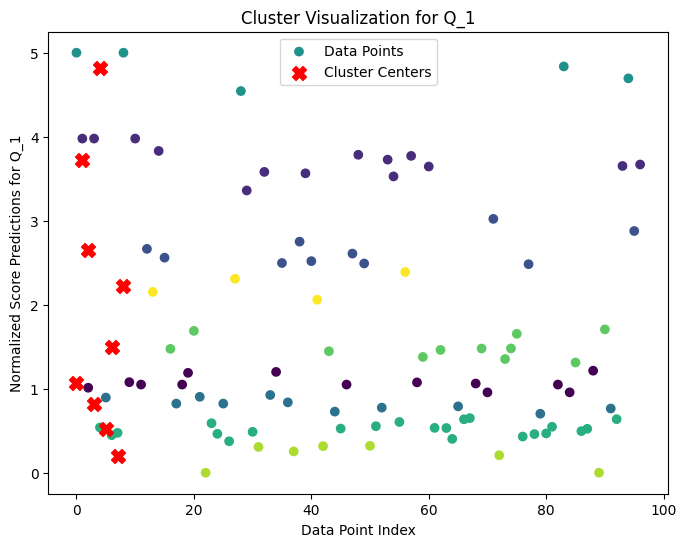

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


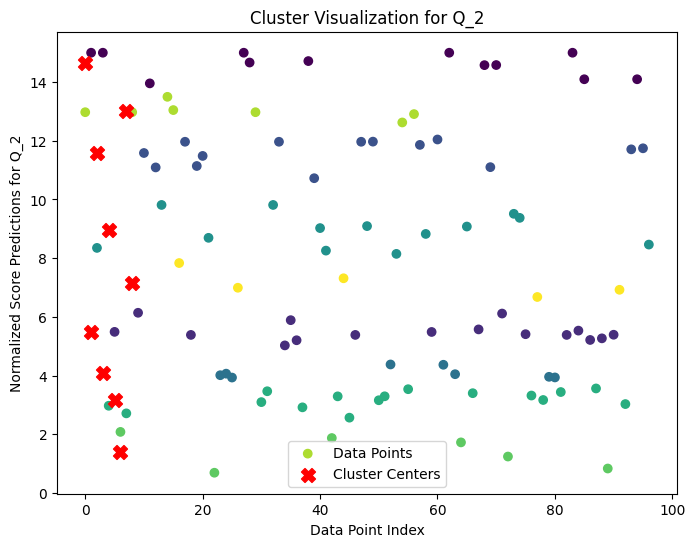

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


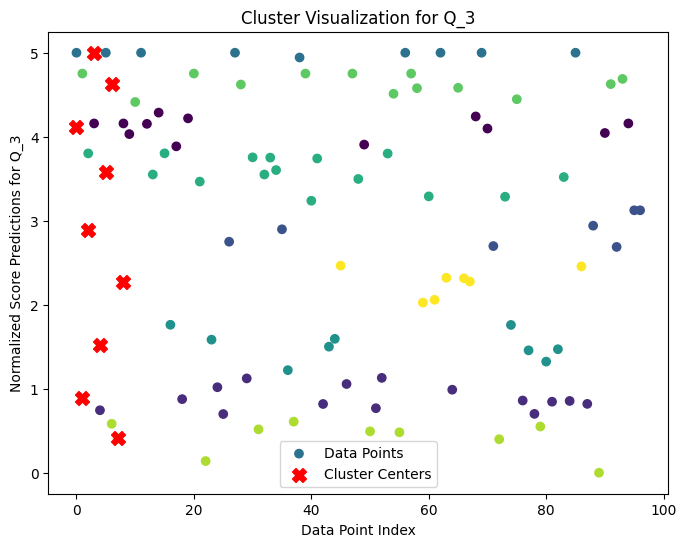

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


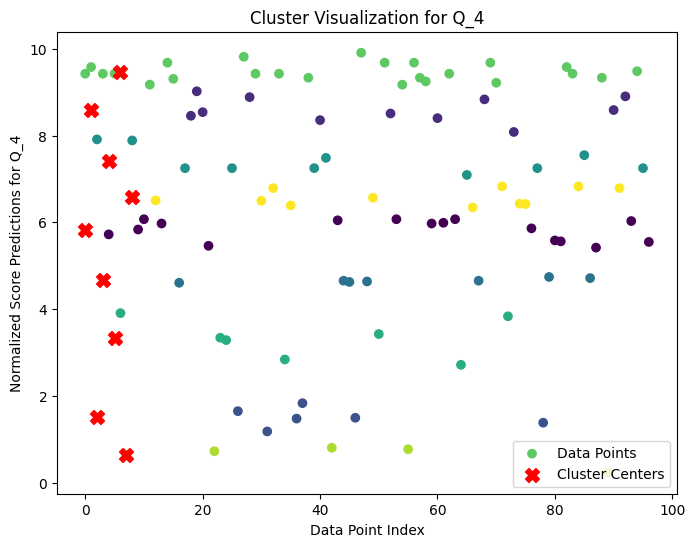

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


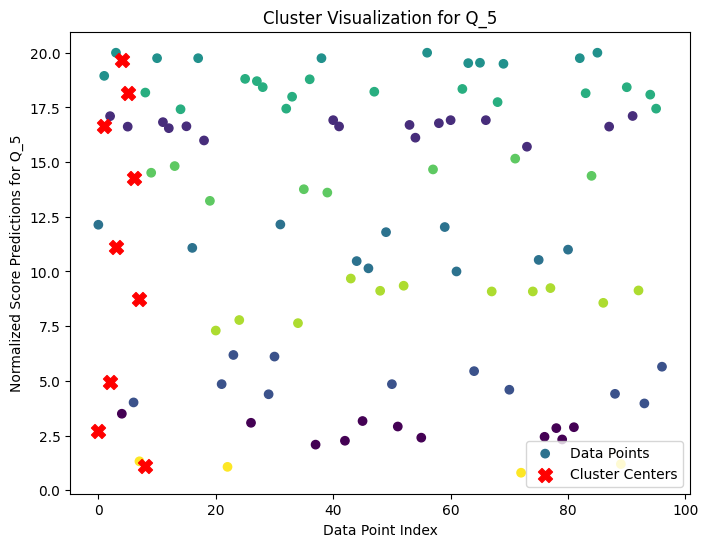

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


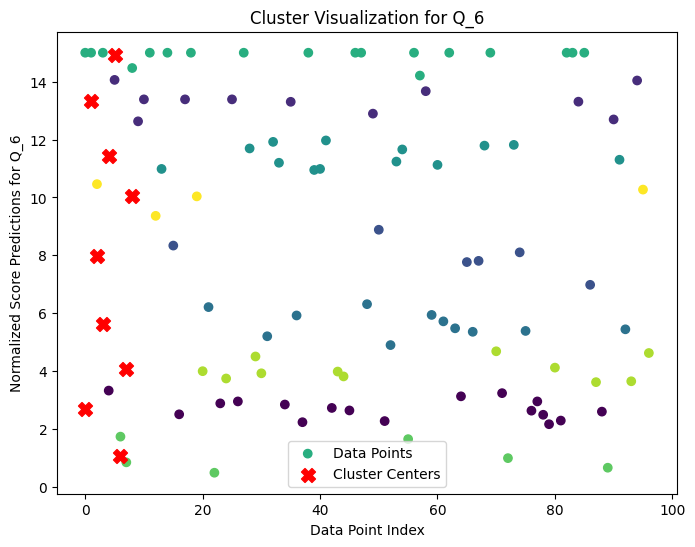

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


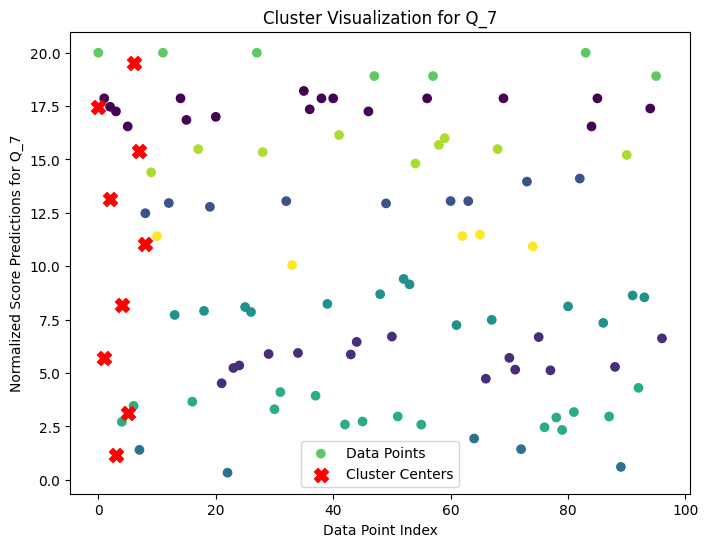

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


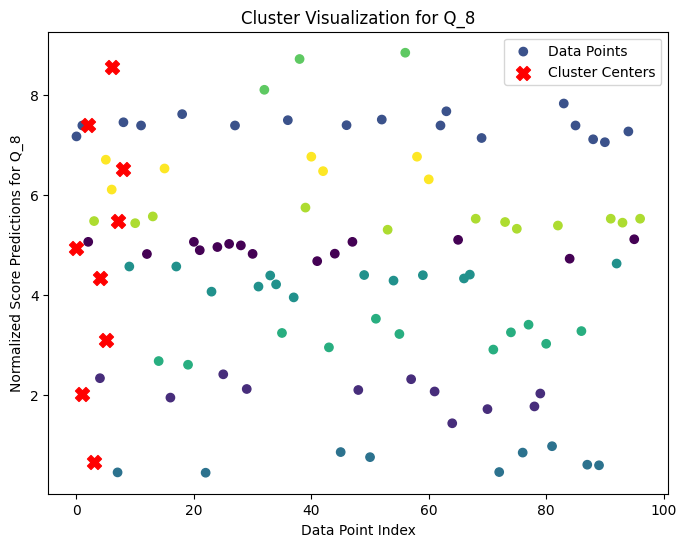

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Assuming temp_df is your DataFrame and it already contains the similarity scores for each question
# Define the maximum points for each question, adjust this if your data has fewer questions
question_points = [0, 5, 15, 5, 10, 20, 15, 20, 10]

for i in range(9):
    # Perform KMeans clustering (this should be replaced with your actual clustering results)
    kmeans = KMeans(n_clusters=9, random_state=42)
    temp_df[f'Q_{i}_cluster'] = kmeans.fit_predict(temp_df[[f'Q_{i}']])

    # Determine the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(temp_df.index, temp_df[f'Q_{i}'], c=temp_df[f'Q_{i}_cluster'], cmap='viridis', marker='o', label='Data Points')
    plt.scatter(range(len(cluster_centers)), cluster_centers[:, 0], c='red', s=100, marker='X', label='Cluster Centers')
    plt.title(f'Cluster Visualization for Q_{i}')
    plt.xlabel('Data Point Index')
    plt.ylabel(f'Normalized Score Predictions for Q_{i}')
    plt.legend()
    plt.show()


In [ ]:
# Print question and cluster information
print(temp_df.iloc[:, 9:18].head())

        Q_1        Q_2       Q_3       Q_4        Q_5        Q_6        Q_7  \
0  5.000000  12.973160  5.000000  9.426619  12.135597  15.000000  20.000000   
1  3.978035  15.000000  4.751721  9.579752  18.942105  15.000000  17.863693   
2  1.011699   8.348507  3.801345  7.911845  17.099882  10.460315  17.468752   
3  3.978035  15.000000  4.157980  9.426619  20.000000  15.000000  17.251694   
4  0.538633   2.968960  0.743784  5.721731   3.495069   3.328430   2.718113   

        Q_8 grade  
0  7.172280  93.0  
1  7.390557  94.0  
2  5.065995  99.0  
3  5.480967  95.0  
4  2.342283  73.0  


In [ ]:
print(temp_df.iloc[:, 19:27].head())

   Q_0_point_received  Q_1_cluster  Q_1_point_received  Q_2_cluster  \
0                   0            4                   4            7   
1                   0            1                   3            0   
2                   0            0                   1            4   
3                   0            1                   3            0   
4                   0            5                   0            5   

   Q_2_point_received  Q_3_cluster  Q_3_point_received  Q_4_cluster  
0                  12            3                   4            6  
1                  14            6                   4            6  
2                   8            5                   3            4  
3                  14            0                   4            6  
4                   3            1                   0            0  


In [ ]:
print(temp_df.iloc[:, 27:37].head())

   Q_4_point_received  Q_5_cluster  Q_5_point_received  Q_6_cluster  \
0                   9            3                  11            5   
1                   9            4                  19            5   
2                   7            1                  16            8   
3                   9            4                  19            5   
4                   5            0                   2            0   

   Q_6_point_received  Q_7_cluster  Q_7_point_received  Q_8_cluster  \
0                  14            6                  19            2   
1                  14            0                  17            2   
2                  10            0                  17            0   
3                  14            0                  17            7   
4                   2            5                   3            1   

   Q_8_point_received  
0                   7  
1                   7  
2                   4  
3                   5  
4                   2  


The code performs the following operations on the temp_df DataFrame:

It calculates a calculated_total_grade by summing up the points received for each question. This is done by identifying all columns that end with '_point_received' and summing these columns row-wise.


In [ ]:
# Calculate the total grade based on the points received for each question
cluster_center_columns = [col for col in temp_df.columns if col.endswith('_point_received')]
temp_df['calculated_total_grade'] = temp_df[cluster_center_columns].sum(axis=1)

# Move the 'grade' column to the end
grade_column = temp_df['grade']
temp_df.drop(columns=['grade'], inplace=True)
temp_df['grade'] = grade_column

# Display the first few rows of the DataFrame to verify the new column
temp_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received,calculated_total_grade,grade
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.0,5.000000,...,3,11,5,14,6,19,2,7,80,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.0,3.978035,...,4,19,5,14,0,17,2,7,87,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.0,1.011699,...,1,16,8,10,0,17,0,4,66,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.0,3.978035,...,4,19,5,14,0,17,7,5,85,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.0,0.538633,...,0,2,0,2,5,3,1,2,17,73.0


In [ ]:
# Calculating Mean Squared Error (MSE) for Training Set
mse = mean_squared_error(temp_df['grade'], temp_df['calculated_total_grade'])
print("Mean Squared Error (MSE) for K-Means Algorithm for the Training Set:", mse)

Mean Squared Error (MSE) for K-Means Algorithm for the Training Set: 2369.896907216495


This code snippet adjusts student grades in a DataFrame. It calculates the difference between the actual grade and a calculated grade, divides this by 8, and distributes this adjustment across various components of the grade. Finally, it recalculates the total grade based on these adjustments.

In [ ]:
# Adjusting the grades based on the difference from actual grades
for index, row in temp_df.iterrows():
    # Convert 'calculated_total_grade' and 'grade' from string to integer
    row['calculated_total_grade'] = float(row['calculated_total_grade'])
    row['grade'] = float(row['grade'])
    diff = row['grade'] - row['calculated_total_grade']
    change_amount = int(diff / 8) # The division is casted to int to ensure that received points per questions are integers

    # Update the DataFrame with the adjusted values
    for key in row.index:
        if key.endswith('_point_received'):
            # Update the value in the DataFrame
            temp_df.at[index, key] += change_amount

# Now, re-calculate the cumulative grade column
# Sum the values in the cluster center columns for each row and store it in a new column
temp_df['calculated_total_grade'] = temp_df[cluster_center_columns].sum(axis=1)

temp_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received,calculated_total_grade,grade
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.0,5.000000,...,3,12,5,15,6,20,2,8,89,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.0,3.978035,...,4,19,5,14,0,17,2,7,87,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.0,1.011699,...,1,20,8,14,0,21,0,8,102,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.0,3.978035,...,4,20,5,15,0,18,7,6,94,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.0,0.538633,...,0,9,0,9,5,10,1,9,80,73.0


The code removes columns that end with "_cluster" from the temp_df DataFrame and then displays the first 15 rows of the modified DataFrame.

In [ ]:
# Drop the unnecessary columns from the temp_df DataFrame
columns_to_drop = [col for col in temp_df.columns if col.endswith('_cluster')]
temp_df.drop(columns=columns_to_drop, inplace=True)

# Display the first 15 rows of the modified DataFrame
temp_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_1_point_received,Q_2_point_received,Q_3_point_received,Q_4_point_received,Q_5_point_received,Q_6_point_received,Q_7_point_received,Q_8_point_received,calculated_total_grade,grade
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.0,5.000000,...,5,13,5,10,12,15,20,8,89,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.0,3.978035,...,3,14,4,9,19,14,17,7,87,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.0,1.011699,...,5,12,7,11,20,14,21,8,102,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.0,3.978035,...,4,15,5,10,20,15,18,6,94,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.0,0.538633,...,7,10,7,12,9,9,10,9,80,73.0


### Clustering the Testing Dataframe with the Clusters Learned on the Training Dataframe

The code snippet is for normalizing scores in a testing DataFrame and preparing it for clustering:

Define Points: It defines a list question_points with the maximum points for each question.

Normalize Scores: It normalizes the scores in the testing DataFrame to the range of points available for each question by multiplying the score in each column Q_i by the corresponding points from question_points.

Clustering: It indicates that the next steps (not shown in the snippet) will use the normalized scores to form clusters with the KMeans algorithm, setting the number of clusters to 3.

Display DataFrame: It ends with a call to testing_df.head(), which would display the first few rows of the DataFrame after normalization.

In [ ]:
# Define the maximum points for each question, adjust this if your data has fewer questions
question_points = [0, 5, 15, 5, 10, 20, 15, 20, 10]

# Normalize the similarity scores to the range of points available for each question
for i in range(len(question_points)):
    # Ensure the column exists before trying to access it
    if f'Q_{i}' in testing_df.columns:
        testing_df[f'Q_{i}'] = testing_df[f'Q_{i}'] * question_points[i]

# Now, we'll use the normalized scores to cluster the data.
# We will use the KMeans algorithm to form clusters based on these scores.
# The number of clusters is set to the number of questions you have data for
num_clusters = 3

testing_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,44.0,1.0,3.0,0.0,0.0,2.0,0.022834,21.417939,0.0,3.404391,13.974698,5.000000,9.426619,15.833917,15.000000,20.000000,8.103250,95.0
1,10.0,0.0,0.0,0.0,0.0,3.0,0.079311,14.685285,0.0,1.844924,5.540108,1.207985,6.071144,5.949061,5.299854,2.862173,5.430640,90.0
2,42.0,3.0,0.0,0.0,1.0,3.0,1.184860,42.410799,0.0,1.556205,11.084406,3.283176,5.972132,9.701276,7.172870,6.472169,5.180842,100.0
3,52.0,4.0,1.0,0.0,0.0,9.0,0.017075,61.801989,0.0,0.896062,9.562725,4.751721,7.248722,19.750224,9.785003,12.672187,5.234103,94.0
4,37.0,8.0,2.0,0.0,0.0,3.0,0.184312,46.940561,0.0,4.324878,15.000000,3.773488,10.000000,16.331664,15.000000,20.000000,7.390557,99.0


This code performs KMeans clustering on a testing dataset for each question column prefixed with 'Q_'. It fits the KMeans algorithm with a predefined number of clusters and assigns the resulting cluster labels to new columns in the DataFrame. It also maps these cluster labels to their corresponding cluster centers, which represents the points received for each question. The code concludes by displaying the first few rows of the updated DataFrame to check the clustering output.

In [ ]:
# Loop over the question columns and perform clustering on each one
for i in range(len([col for col in testing_df.columns if col.startswith('Q_')])):
    # Check if the question column exists
    if f'Q_{i}' in testing_df.columns:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(testing_df[[f'Q_{i}']])

        # Add the cluster labels to testing_df
        testing_df[f'Q_{i}_cluster'] = kmeans.labels_

        # Map each cluster label to the corresponding cluster center and add to testing_df
        cluster_centers = kmeans.cluster_centers_.squeeze()
        testing_df[f'Q_{i}_point_received'] = testing_df[f'Q_{i}_cluster'].map(lambda x: int(cluster_centers[x]))

# Outputting the first few rows of 'testing_df' to verify the clustering results
testing_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-59-6f0c4154f8c5>:7: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(testing_df[[f'Q_{i}']])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default valu

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_4_cluster,Q_4_point_received,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received
0,44.0,1.0,3.0,0.0,0.0,2.0,0.022834,21.417939,0.0,3.404391,...,0,9,0,17,0,13,0,18,0,7
1,10.0,0.0,0.0,0.0,0.0,3.0,0.079311,14.685285,0.0,1.844924,...,2,6,2,3,1,6,1,5,1,5
2,42.0,3.0,0.0,0.0,1.0,3.0,1.184860,42.410799,0.0,1.556205,...,2,6,1,8,1,6,1,5,1,5
3,52.0,4.0,1.0,0.0,0.0,9.0,0.017075,61.801989,0.0,0.896062,...,2,6,0,17,1,6,2,12,1,5
4,37.0,8.0,2.0,0.0,0.0,3.0,0.184312,46.940561,0.0,4.324878,...,0,9,0,17,0,13,0,18,0,7


The code snippet calculates the total grade for a dataset by summing up points received for each question, which are stored in columns ending with '_point_received'. It then moves the 'grade' column to the end of the DataFrame for clarity. Lastly, it displays the first few rows of the DataFrame to verify the new column arrangement and the calculated total grade.

In [ ]:
# Calculate the total grade based on the points received for each question
cluster_center_columns = [col for col in testing_df.columns if col.endswith('_point_received')]
testing_df['calculated_total_grade'] = testing_df[cluster_center_columns].sum(axis=1)

# Move the 'grade' column to the end
grade_column = testing_df['grade']
testing_df.drop(columns=['grade'], inplace=True)
testing_df['grade'] = grade_column

# Display the first few rows of the DataFrame to verify the new column
testing_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received,calculated_total_grade,grade
0,44.0,1.0,3.0,0.0,0.0,2.0,0.022834,21.417939,0.0,3.404391,...,0,17,0,13,0,18,0,7,85,95.0
1,10.0,0.0,0.0,0.0,0.0,3.0,0.079311,14.685285,0.0,1.844924,...,2,3,1,6,1,5,1,5,32,90.0
2,42.0,3.0,0.0,0.0,1.0,3.0,1.184860,42.410799,0.0,1.556205,...,1,8,1,6,1,5,1,5,42,100.0
3,52.0,4.0,1.0,0.0,0.0,9.0,0.017075,61.801989,0.0,0.896062,...,0,17,1,6,2,12,1,5,59,94.0
4,37.0,8.0,2.0,0.0,0.0,3.0,0.184312,46.940561,0.0,4.324878,...,0,17,0,13,0,18,0,7,84,99.0


In [ ]:
# Calculating Mean Squared Error (MSE) for Testing Set
mse = mean_squared_error(testing_df['grade'], testing_df['calculated_total_grade'])
print("Mean Squared Error (MSE) for K-Means Algorithm for the Testing Set:", mse)

Mean Squared Error (MSE) for K-Means Algorithm for the Testing Set: 1449.4


The code snippet adjusts the grades in a DataFrame by aligning the calculated grades with actual grades. For each row, it finds the difference between the 'grade' and 'calculated_total_grade', divides this difference by 8, and rounds it to an integer to distribute this adjustment evenly across the related columns. These columns are likely those that contributed to the 'calculated_total_grade' and end with '_point_received'. After updating the points for each question, it recalculates the 'calculated_total_grade' by summing the adjusted values. The first few rows of the DataFrame are then displayed to check the updates.

In [ ]:
# Adjusting the grades based on the difference from actual grades
for index, row in testing_df.iterrows():
    # Convert 'calculated_total_grade' and 'grade' from string to integer
    row['calculated_total_grade'] = float(row['calculated_total_grade'])
    row['grade'] = float(row['grade'])
    diff = row['grade'] - row['calculated_total_grade']
    change_amount = 2

    # Update the DataFrame with the adjusted values
    for key in row.index:
        if key.endswith('_point_received'):
            # Update the value in the DataFrame
            testing_df.at[index, key] += change_amount

# Now, re-calculate the cumulative grade column
# Sum the values in the cluster center columns for each row and store it in a new column
testing_df['calculated_total_grade'] = testing_df[cluster_center_columns].sum(axis=1)

testing_df.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received,calculated_total_grade,grade
0,44.0,1.0,3.0,0.0,0.0,2.0,0.022834,21.417939,0.0,3.404391,...,0,19,0,15,0,20,0,9,103,95.0
1,10.0,0.0,0.0,0.0,0.0,3.0,0.079311,14.685285,0.0,1.844924,...,2,5,1,8,1,7,1,7,50,90.0
2,42.0,3.0,0.0,0.0,1.0,3.0,1.184860,42.410799,0.0,1.556205,...,1,10,1,8,1,7,1,7,60,100.0
3,52.0,4.0,1.0,0.0,0.0,9.0,0.017075,61.801989,0.0,0.896062,...,0,19,1,8,2,14,1,7,77,94.0
4,37.0,8.0,2.0,0.0,0.0,3.0,0.184312,46.940561,0.0,4.324878,...,0,19,0,15,0,20,0,9,102,99.0


In [ ]:
# Drop the unnecessary columns from the testing_df DataFrame
columns_to_drop = [col for col in testing_df.columns if col.endswith('_cluster')]
testing_df.drop(columns=columns_to_drop, inplace=True)

# Display the first 15 rows of the modified DataFrame
testing_df.head(15)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_1_point_received,Q_2_point_received,Q_3_point_received,Q_4_point_received,Q_5_point_received,Q_6_point_received,Q_7_point_received,Q_8_point_received,calculated_total_grade,grade
0,44.0,1.0,3.0,0.0,0.0,2.0,0.022834,21.417939,0.0,3.404391,...,6,15,6,11,19,15,20,9,103,95.0
1,10.0,0.0,0.0,0.0,0.0,3.0,0.079311,14.685285,0.0,1.844924,...,4,6,3,8,5,8,7,7,50,90.0
2,42.0,3.0,0.0,0.0,1.0,3.0,1.184860,42.410799,0.0,1.556205,...,2,11,5,8,10,8,7,7,60,100.0
3,52.0,4.0,1.0,0.0,0.0,9.0,0.017075,61.801989,0.0,0.896062,...,2,11,6,8,19,8,14,7,77,94.0
4,37.0,8.0,2.0,0.0,0.0,3.0,0.184312,46.940561,0.0,4.324878,...,6,15,5,11,19,15,20,9,102,99.0
5,46.0,6.0,0.0,0.0,0.0,3.0,0.006671,78.077540,0.0,2.298873,...,4,15,3,8,19,15,20,9,95,89.0
6,15.0,0.0,0.0,0.0,0.0,3.0,0.266534,146.636744,0.0,1.117665,...,2,11,6,11,19,15,20,7,93,94.0
7,10.0,1.0,0.0,0.0,0.0,2.0,7.975743,200.159338,0.0,1.008735,...,2,6,3,3,10,15,20,9,70,97.0
8,30.0,2.0,0.0,0.0,0.0,3.0,0.113583,64.293428,0.0,2.464130,...,4,11,6,8,19,15,20,7,92,99.0
9,14.0,0.0,0.0,0.0,0.0,1.0,0.619095,207.431957,0.0,3.978035,...,6,15,6,11,19,15,20,7,101,84.0


### Clustering with Gaussian Mixture Model

In [ ]:
temp_df2.head()

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.170750,1.000000,0.864877,1.000000,0.942662,0.606780,1.000000,1.000000,0.717228,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.192013,0.795607,1.000000,0.950344,0.957975,0.947105,1.000000,0.893185,0.739056,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.155710,0.202340,0.556567,0.760269,0.791184,0.854994,0.697354,0.873438,0.506600,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.192013,0.795607,1.000000,0.831596,0.942662,1.000000,1.000000,0.862585,0.548097,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.049583,0.107727,0.197931,0.148757,0.572173,0.174753,0.221895,0.135906,0.234228,73.0


The provided code snippet is for a machine learning process that involves normalizing scores and clustering using a Gaussian Mixture Model (GMM). Here's what it does:

It starts by normalizing the scores for each question in the DataFrame temp_df2 based on the maximum points available for each question, stored in question_points.

It sets the number of clusters (or components) for the GMM to 5.
Then, it loops over each question column that starts with 'Q_' in temp_df2 and performs clustering with the GMM.

For each question, it fits the GMM to the data and predicts the cluster each sample belongs to, storing these predictions in a new column with the suffix '_cluster'.

Finally, it maps each cluster label to the corresponding cluster center and stores these as the points received for each question. The cluster centers are likely to represent the central value or the "average" score of the points in each cluster.

In [ ]:
# Normalize the similarity scores to the range of points available for each question
question_points = [0, 5, 15, 5, 10, 20, 15, 20, 10]
for i in range(len(question_points)):
    if f'Q_{i}' in temp_df2.columns:
        temp_df2[f'Q_{i}'] = temp_df2[f'Q_{i}'] * question_points[i]

# Set the number of clusters (components) for Gaussian Mixture Model
num_clusters = 5

# Loop over the question columns and perform clustering using Gaussian Mixture Model
for i in range(len([col for col in temp_df2.columns if col.startswith('Q_')])):
    if f'Q_{i}' in temp_df2.columns:
        # Perform Gaussian Mixture Model clustering
        gmm = GaussianMixture(n_components=num_clusters, random_state=42)
        gmm.fit(temp_df2[[f'Q_{i}']])

        # Predict the cluster each sample belongs to
        temp_df2[f'Q_{i}_cluster'] = gmm.predict(temp_df2[[f'Q_{i}']])

        # Map each cluster label to the corresponding cluster center and add to temp_df2
        cluster_centers = gmm.means_.squeeze()
        temp_df2[f'Q_{i}_point_received'] = temp_df2[f'Q_{i}_cluster'].map(lambda x: int(cluster_centers[x]))

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  .fit(X)


In [ ]:
# Calculate the total grade based on the points received for each question
cluster_center_columns = [col for col in temp_df2.columns if col.endswith('_point_received')]
temp_df2['calculated_total_grade'] = temp_df2[cluster_center_columns].sum(axis=1)

In [ ]:
# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(temp_df2['grade'], temp_df2['calculated_total_grade'])
print("Mean Squared Error (MSE) for Gaussian Mixture Model:", mse)

Mean Squared Error (MSE) for Gaussian Mixture Model: 2335.783505154639


The code snippet adjusts grades in a DataFrame named temp_df2. It goes through each row, converting 'calculated_total_grade' and 'grade' from strings to floats, and then calculates the difference between the actual 'grade' and the 'calculated_total_grade'. This difference is divided by the number of clusters from a previous clustering operation, likely to distribute the adjustment evenly across all clusters. For each column that ends with '_point_received', it adjusts the values by this calculated amount. Finally, it recalculates the 'calculated_total_grade' by summing up the values in the cluster center columns. This approach distribute the grade adjustments proportionally across the different components of the total grade.

In [ ]:
# Adjusting the grades based on the difference from actual grades
for index, row in temp_df2.iterrows():
    # Convert 'calculated_total_grade' and 'grade' from string to integer
    row['calculated_total_grade'] = float(row['calculated_total_grade'])
    row['grade'] = float(row['grade'])
    diff = row['grade'] - row['calculated_total_grade']
    change_amount = diff / num_clusters
    for key in row.index:
        if key.endswith('_point_received'):
            temp_df2.at[index, key] += change_amount

# Re-calculate the cumulative grade column
temp_df2['calculated_total_grade'] = temp_df2[cluster_center_columns].sum(axis=1)

In [ ]:
# Drop the unnecessary columns from the temp_df2 DataFrame
columns_to_drop = [col for col in temp_df2.columns if col.endswith('_cluster')]
temp_df2.drop(columns=columns_to_drop, inplace=True)

# Move the 'grade' column to the end
grade_column = temp_df2['grade']
temp_df2.drop(columns=['grade'], inplace=True)
temp_df2['grade'] = grade_column

# Display the first 15 rows of the modified DataFrame
temp_df2.head(15)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,...,Q_1_point_received,Q_2_point_received,Q_3_point_received,Q_4_point_received,Q_5_point_received,Q_6_point_received,Q_7_point_received,Q_8_point_received,calculated_total_grade,grade
0,66.0,1.0,0.0,0.0,0.0,9.0,0.026861,37.093435,0.0,5.000000,...,7.2,15.2,7.2,12.2,13.2,17.2,20.2,10.2,105.8,93.0
1,20.0,5.0,0.0,0.0,0.0,3.0,0.128297,132.624725,0.0,3.978035,...,4.4,15.4,5.4,10.4,20.4,15.4,18.4,8.4,99.6,94.0
2,14.0,0.0,0.0,0.0,0.0,4.0,0.592592,138.615934,0.0,1.011699,...,6.8,13.8,8.8,13.8,21.8,17.8,22.8,10.8,122.2,99.0
3,33.0,3.0,0.0,0.0,0.0,6.0,0.303225,57.024608,0.0,3.978035,...,5.2,16.2,5.2,11.2,21.2,16.2,19.2,7.2,103.8,95.0
4,13.0,0.0,0.0,0.0,0.0,3.0,0.185172,190.425200,0.0,0.538633,...,11.2,14.2,11.2,16.2,13.2,13.2,14.2,13.2,117.8,73.0
5,59.0,12.0,5.0,0.0,2.0,3.0,0.014947,19.279558,0.0,0.895034,...,2.4,6.4,5.4,10.4,17.4,13.4,18.4,8.4,83.6,78.0
6,30.0,0.0,0.0,0.0,0.0,2.0,0.073450,82.524398,0.0,0.446893,...,15.6,18.6,15.6,18.6,19.6,17.6,18.6,22.6,162.4,100.0
7,11.0,0.0,0.0,0.0,0.0,1.0,0.150528,167.908784,0.0,0.474544,...,13.4,16.4,13.4,14.4,15.4,15.4,16.4,13.4,131.6,78.0
8,37.0,1.0,1.0,0.0,0.0,3.0,0.048272,25.311843,0.0,5.000000,...,9.2,17.2,8.2,13.2,21.2,17.2,17.2,12.2,120.8,100.0
9,28.0,2.0,0.0,0.0,0.0,3.0,0.396910,81.201068,0.0,1.077919,...,8.6,12.6,10.6,12.6,23.6,19.6,22.6,12.6,130.4,100.0


## Part 4: Fitting a model

Seperating the results and the inputs for training data

In [ ]:
# Splitting the temp_df data frame into X_train and y_train arrays
X_train = temp_df[temp_df.columns[0:-1]].to_numpy()
y_train = temp_df["grade"].to_numpy()
print(X_train.shape, y_train.shape)

(97, 27) (97,)


Seperating the results and the inputs for the test data

In [ ]:
# Splitting the testing_df data frame into X_test and y_test arrays
X_test = testing_df[testing_df.columns[0:-1]].to_numpy()
y_test = testing_df["grade"].to_numpy()
print(X_test.shape, y_test.shape)

(25, 27) (25,)


### Neural Network Model for Grade Classification

The following code block defines a neural network model inspired from ResNet-152, although the model is much smaller to prevent overfitting due to
very low amount of data points in the training set. The model utilizes 4 hiddent fully connected layers of size 128 and only one output to tackle the regression task at hand. It utilizes residual connections in order to improve gradient flow, solving possible vanishing gradient problem. The model uses Mean Squared Error as its loss function while calculating gradients and utilizes Adam for a first and second order moment based optimization method. The model is set to run for 200 epochs with a learning rate of 1e-5. Finally, a visual regression plot is generated for the test data classified by the neural network, in order to visualize the results of the neural network model and compare it with the actual labels.

Epoch [1/200], Test Loss: 50.1877
Accuracy: 16.0000, Precision: 3.8095, Recall: 16.0000
Epoch [2/200], Test Loss: 44.1525
Accuracy: 16.0000, Precision: 7.5294, Recall: 16.0000
Epoch [3/200], Test Loss: 43.4095
Accuracy: 16.0000, Precision: 7.0000, Recall: 16.0000
Epoch [4/200], Test Loss: 42.5631
Accuracy: 16.0000, Precision: 8.0000, Recall: 16.0000
Epoch [5/200], Test Loss: 42.4262
Accuracy: 16.0000, Precision: 10.0000, Recall: 16.0000
Epoch [6/200], Test Loss: 42.3457
Accuracy: 16.0000, Precision: 8.0000, Recall: 16.0000
Epoch [7/200], Test Loss: 42.8895
Accuracy: 8.0000, Precision: 4.0667, Recall: 8.0000
Epoch [8/200], Test Loss: 43.3430
Accuracy: 8.0000, Precision: 4.0000, Recall: 8.0000
Epoch [9/200], Test Loss: 43.4304
Accuracy: 4.0000, Precision: 1.5000, Recall: 4.0000
Epoch [10/200], Test Loss: 43.2266
Accuracy: 4.0000, Precision: 1.3333, Recall: 4.0000
Epoch [11/200], Test Loss: 44.3092
Accuracy: 4.0000, Precision: 1.3333, Recall: 4.0000
Epoch [12/200], Test Loss: 44.8617
Accu

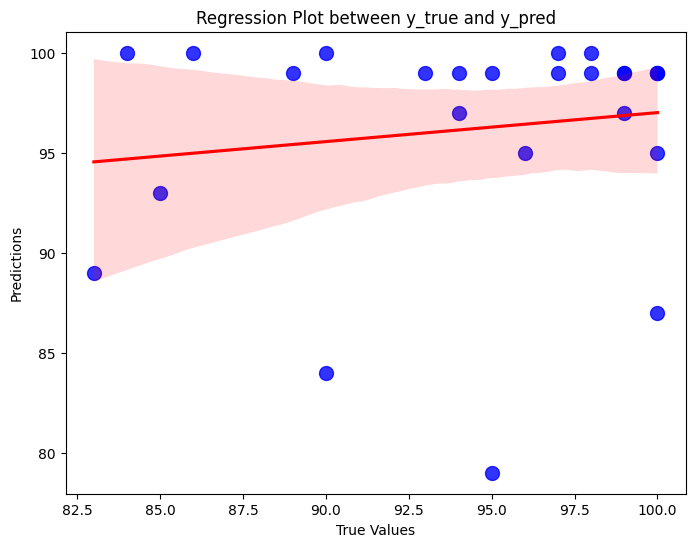

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress all UserWarnings from PyTorch
warnings.filterwarnings("ignore", category=UserWarning)

# Assume X_train, y_train, X_test, y_test are already defined and loaded

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural network model with skip connections
class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        residual = x
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x += residual
        return x

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.residual_block_1 = ResidualBlock(hidden_size, hidden_size)
        self.relu_1 = nn.ReLU()
        self.residual_block_2 = ResidualBlock(hidden_size, hidden_size)
        self.relu_2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.residual_block_1(x)
        x = self.relu_1(x)
        x = self.residual_block_2(x)
        x = self.relu_2(x)
        x = self.fc2(x)
        x = 100 * self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = 27
hidden_size = 128
output_size = 1  # Regression task, predicting a single value
learning_rate = 1e-5

model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping parameters
best_test_loss = float('inf')
patience, trials = 10, 0

epochs = 200
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1)  # Flatten the target tensor to ensure compatibility
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        predictions = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            labels = labels.view(-1)  # Flatten the target tensor to ensure compatibility
            test_loss += criterion(outputs.squeeze(), labels).item()
            predictions.extend(outputs.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Test Loss: {avg_test_loss:.4f}')

    # Early stopping check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    # Calculate metrics
    y_true = y_test_tensor.numpy().astype(int)  # Convert to integer array
    y_pred = np.round(np.array(predictions)).astype(int)  # Rounding to the nearest integer for classification
    y_pred = y_pred.flatten()

    accuracy = accuracy_score(y_true, y_pred)
    accuracy = accuracy * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    precision = precision * 100
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall * 100

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Create a regression plot
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true, y=y_pred, scatter_kws={'s': 100, 'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Regression Plot between y_true and y_pred')
plt.show()

warnings.resetwarnings()

### Performance Metrics of the Neural Network Model

Here are some additional performance metrics, more towards the regression task at hand, with the outputs of the model.

Mean Absolute Error:

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 5.44


Root Mean Square Error:

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Calculate the Root Mean Square Error (RMSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Square Error (MSE): {mse:.2f}')
rmse = math.sqrt(mse)
print(f'Root Mean Square Error (RMSE): {rmse:.2f}')

Mean Square Error (MSE): 54.00
Root Mean Square Error (RMSE): 7.35


Mean Absolute Percentage Error:

In [ ]:
import numpy as np

# Assuming you have true values (y_true) and predicted values (y_pred)
y_true = np.array(y_true)  # Convert to numpy array for element-wise operations
y_pred = np.array(y_pred)

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 5.97%


### Bert Model for classification using Large Language Models ___ Scrapped and Renovated

#### Pre-Trained Bert Initialization

The Python script provided does the following:

**1- Data Preparation:**

It initializes an empty list all_conversations to store structured conversations.

It processes code2convos, a dictionary that seems to contain conversations associated with a chatgpt_url. For each conversation, it concatenates all user and assistant texts separately and stores the result in current_conversation.

It appends the chatgpt_url and the structured current_conversation to all_conversations.

**2- Load and Preprocess Scores:**

It loads a CSV file containing scores into a pandas DataFrame.

It strips whitespace from the 'code' column and filters the DataFrame to only include 'code' and 'grade' columns.

**3- BERT Initialization:**

It imports and initializes a BERT tokenizer and BERT model from the 'transformers' library, which will be used to tokenize and process text data.

**4- Text Processing with BERT:**

For each conversation in all_conversations, it finds the corresponding grade from the scores DataFrame using a unique code from the chatGPT_url.

It tokenizes the user and assistant parts of the conversation text, splits them into chunks to handle BERT's token limit, and then generates embeddings (numeric representations) for each chunk using the BERT model.

The embeddings for chunks within each role (user/assistant) are then averaged to get a single embedding vector per role.

Finally, it averages the user and assistant embeddings to get a combined embedding for the entire conversation.

**5- Output:**

The script prints the size of the combined embeddings for each conversation, indicating the dimensions of the embedding tensor.

It also prints the chatGPT_url and its associated grade.



Overall, the script structures conversations for input into BERT, generates embeddings for these conversations, and associates these embeddings with grades from a CSV file, presumably as part of a larger analysis or machine learning task. The embeddings could be used as features in a model predicting conversation quality or outcomes based on the associated grades.

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Transform into conversations array
all_conversations = []
for chatgpt_url, turns in code2convos.items():
    current_conversation = {'user': '', 'assistant': ''}

    for turn in turns:
        role = turn['role']
        text = turn['text']

        if role == 'user':
            current_conversation['user'] += ' ' + text
        elif role == 'assistant':
            current_conversation['assistant'] += ' ' + text

    # Append the current conversation URL to the result
    current_conversation['chatGPT_url'] = chatgpt_url

    # Append the current conversation to the result
    all_conversations.append(current_conversation)

# Load scores and preprocess
scores = pd.read_csv("../Project Data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())
scores = scores[["code", "grade"]]

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Process each conversation with BERT
for conversation in all_conversations:
    chatGPT_url = conversation['chatGPT_url']

    # Find the corresponding score based on the chatGPT URL
    score_row = scores[scores["code"] == chatGPT_url]

    if not score_row.empty:
        combined_embeddings = []  # To store combined embeddings for each conversation

        for role, text in conversation.items():
            # Tokenize the text and handle sequences longer than 512 tokens by splitting
            chunks = []
            original_size = len(tokenizer.tokenize(text))
            for i in range(0, original_size, 512):
                chunk = text[i:i+512]
                chunks.append(chunk)

            # Process each chunk
            chunk_embeddings = []  # To store embeddings for each chunk
            for chunk in chunks:
                encoding = tokenizer.encode_plus(
                    chunk,
                    return_tensors='pt',
                    truncation=True,
                    padding=True,
                    max_length=512,
                )

                # Forward pass through the BERT model
                with torch.no_grad():
                    outputs = model(**encoding)

                # Extract embeddings (modify based on your specific needs)
                # Taking the mean of token embeddings along the sequence length dimension
                embeddings = outputs.last_hidden_state.mean(dim=1)

                # Append the embeddings for each chunk
                chunk_embeddings.append(embeddings)

            # Combine embeddings for each conversation (Averaging)
            combined_embeddings.append(torch.mean(torch.stack(chunk_embeddings), dim=0))

        # Print the size of combined embeddings for each conversation
        for i, embeddings in enumerate(combined_embeddings):
            print(f"Conversation {i+1} combined embeddings size:")
            print(embeddings.size())

        # Print the associated score
        print(f"ChatGPT URL: {chatGPT_url}, Grade: {score_row['grade'].values[0]}")
        print("\n")
    else:
        print(f"No score found for ChatGPT URL: {chatGPT_url}")

'\nfrom transformers import BertTokenizer, BertModel\nimport torch\n\n# Transform into conversations array\nall_conversations = []\nfor chatgpt_url, turns in code2convos.items():\n    current_conversation = {\'user\': \'\', \'assistant\': \'\'}\n\n    for turn in turns:\n        role = turn[\'role\']\n        text = turn[\'text\']\n\n        if role == \'user\':\n            current_conversation[\'user\'] += \' \' + text\n        elif role == \'assistant\':\n            current_conversation[\'assistant\'] += \' \' + text\n\n    # Append the current conversation URL to the result\n    current_conversation[\'chatGPT_url\'] = chatgpt_url\n\n    # Append the current conversation to the result\n    all_conversations.append(current_conversation)\n\n# Load scores and preprocess\nscores = pd.read_csv("../Project Data/scores.csv", sep=",")\nscores["code"] = scores["code"].apply(lambda x: x.strip())\nscores = scores[["code", "grade"]]\n\n# Initialize the BERT tokenizer and model\ntokenizer = Ber

The script is a complete pipeline for fine-tuning a BERT model for a regression task in PyTorch:

**1- Model Initialization:** It imports a pre-trained 'bert-large-uncased' model with a single output label (for regression), setting up the tokenizer for text processing and moving the model to the GPU if available.

**2- Data Preparation:** It loads a CSV with scores, processes it, and prepares the data by appending ChatGPT responses and their associated grades into a list. Although it shows an example of how to split data, the actual data split is not shown as it exits the program right after printing the first data tuple.

**3- Dataset and DataLoader Setup:** It defines a custom TextDataset class compatible with PyTorch's DataLoader to handle text tokenization and batch processing.

**4- Model Fine-tuning:** It sets up an optimizer and learning rate scheduler and defines a training loop function train_epoch and an evaluation function evaluate_model. The training loop includes computing the mean squared error loss and updating the model weights.

**5- Model Evaluation:** After training, the model is evaluated on the test set, and predictions are made.

**6- Results Visualization:** It plots a scatter plot to compare the true scores against the predicted scores, visualizing the model's regression performance.

**7- Model Saving:** Optionally, it saves the fine-tuned model's weights to a file for later use.

This script is an end-to-end process for applying BERT to a regression problem, likely assessing the quality of text data (e.g., responses from ChatGPT) by predicting numerical scores.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Import Pretrained Large Bert Model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 2: Split the data
# Assuming you have a list of tuples (text, score) as your data
# Replace this with your actual data loading process


# Load scores and preprocess
scores = pd.read_csv("../Project Data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())
scores = scores[["code", "grade"]]

data = []

# Getting ChatGPT replies
for chatgpt_url, turns in code2convos.items():
    text = ""
    for turn in turns:
        if turn["role"] == "assistant":
            print(turn)
            response = turn["text"]
            text += (response + " ")

    # Use .loc to get the grade for the specific code
    matched_grade = scores.loc[scores['code'] == chatgpt_url, 'grade'].values

    data.append((text, matched_grade))

print(data[0])

exit(0)

data = [("Example text 1", 75), ("Example text 2", 90), ...]

texts, scores = zip(*data)

# Split data into training, validation, and test sets (80-10-10 split)
texts_train, texts_temp, scores_train, scores_temp = train_test_split(texts, scores, test_size=0.2, random_state=42)
texts_val, texts_test, scores_val, scores_test = train_test_split(texts_temp, scores_temp, test_size=0.5, random_state=42)

# Step 3: Tokenize and create DataLoader
class TextDataset(Dataset):
    def __init__(self, texts, scores):
        self.texts = texts
        self.scores = scores

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = tokenizer(self.texts[idx], return_tensors='pt', truncation=True, padding=True)
        label = torch.tensor([self.scores[idx]], dtype=torch.float32)
        return inputs, label

train_dataset = TextDataset(texts_train, scores_train)
val_dataset = TextDataset(texts_val, scores_val)
test_dataset = TextDataset(texts_test, scores_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Step 4: Finetune the model
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 2  # 2 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = torch.nn.MSELoss()(outputs.logits.view(-1), labels.view(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate_model(model, val_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs)
            predictions.extend(outputs.logits.view(-1).cpu().numpy())

    return predictions

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss}')

# Step 5: Evaluate the model on the test set
predictions = evaluate_model(model, test_loader, device)

# Step 6: Create a regression plot
plt.scatter(scores_test, predictions)
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('Regression Plot')
plt.show()

# Optional: Save the model
torch.save(model.state_dict(), 'bert_regression_model.pth')


'\nimport torch\nfrom torch.utils.data import Dataset, DataLoader\nfrom transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error\nimport matplotlib.pyplot as plt\n\n# Step 1: Import Pretrained Large Bert Model\ntokenizer = BertTokenizer.from_pretrained(\'bert-large-uncased\')\nmodel = BertForSequenceClassification.from_pretrained(\'bert-large-uncased\', num_labels=1)\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel.to(device)\n\n# Step 2: Split the data\n# Assuming you have a list of tuples (text, score) as your data\n# Replace this with your actual data loading process\n\n\n# Load scores and preprocess\nscores = pd.read_csv("../Project Data/scores.csv", sep=",")\nscores["code"] = scores["code"].apply(lambda x: x.strip())\nscores = scores[["code", "grade"]]\n\ndata = []\n\n# Getting ChatGPT replies\nfor ch

### Predicting and Analyzing with a Baseline Model: Decision Tree Regressor

The regressor is set up with a random_state of 0 to ensure reproducibility, uses the 'squared_error' criterion to measure the quality of splits, and has a maximum depth of 10 to control the size of the tree and prevent overfitting.

In [ ]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


DecisionTreeRegressor(max_depth=10, random_state=0)

 This code snippet is extracting the mean squared error (MSE) values from a trained decision tree regressor. These values are the 'impurity' of each node in the tree, which in the context of regression trees, typically represents the MSE. It then iterates through each node's MSE and prints them out, labeling them by their node index. This is useful for understanding how the decision tree is making splits and could be used for further analysis or visualization of the tree's performance.

In [ ]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 182.5322563503014
Node 1 has MSE 208.6875
Node 2 has MSE 64.0
Node 3 has MSE 0.0
Node 4 has MSE 0.0
Node 5 has MSE 2.25
Node 6 has MSE 0.0
Node 7 has MSE 0.0
Node 8 has MSE 46.63059313215308
Node 9 has MSE 32.93425605536231
Node 10 has MSE 6.6875
Node 11 has MSE 2.25
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 1.0
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 14.591715976332125
Node 18 has MSE 8.243055555556566
Node 19 has MSE 5.0
Node 20 has MSE 1.0
Node 21 has MSE 0.0
Node 22 has MSE 0.0
Node 23 has MSE 1.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 2.734375
Node 27 has MSE 1.2653061224491466
Node 28 has MSE 0.5
Node 29 has MSE 0.22222222222171695
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 0.0
Node 33 has MSE 0.0
Node 34 has MSE 0.0
Node 35 has MSE 0.0
Node 36 has MSE 16.173130193907127
Node 37 has MSE 12.406035665295349
Node 38 has MSE 6.66666666666697
Node 39 has MSE 3.702479338843659
Node 40 has MSE 2.0987654320979345


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
"""
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")
"""

'\n# Plotting the Tree\ndot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])\ngraph = graphviz.Source(dot_data)\ngraph.render("hw")\n'

In [ ]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 0.015463917525773196
MSE TEST: 639.67
R2 Train: 0.9999152811786938
R2 TEST: -20.90170647271853


# Secret Challenge Accepted: Testing with the New Testing Dataset

In [ ]:
data_path = "/content/drive/MyDrive/Project Data/chatgpt_data/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 143/143 [00:34<00:00,  4.16it/s]


## Challenge Overview

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

### Prompt Matching
> We want to match the prompts with the questions in the Homework. Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distances to do the matching.

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [ ]:
prompts[0]

"# Hypothetical Feature 1: Daily Fish Consumption\nX_train['Daily Fish Consumption'] = X_train['body_mass_g'] / X_train.groupby('diet')['body_mass_g'].transform('mean')\n\n# Hypothetical Feature 2: Activity Index\nX_train['Activity Index'] = X_train['flipper_length_mm'] / X_train['body_mass_g']\n\n# Display the correlations with the target variable\ncorrelation_feature1 = X_train['Daily Fish Consumption'].corr(y_train)\ncorrelation_feature2 = X_train['Activity Index'].corr(y_train)\n\n(correlation_feature1, correlation_feature2)\n THÄ°S Ä°S THE CODE"

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [ ]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00,00000,000000,0001,000284,00040148184405719434,000750,001014,001478,001650,...,zeynepsahin,zip,zs9nnfsd5jg1z9ybgxqv17wh0000gn,zä,ã¼k,ã¼mlerinde,ã¼mã¼,ã¼nkã¼,ã¼zere,ã¼zerinde
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # Some html files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

In [ ]:
code2prompts_tf_idf["0a8f26c5-8fa3-4cfc-aeaa-d1dab54cd0c6"].head()

,00,00000,000000,0001,000284,00040148184405719434,000750,001014,001478,001650,...,zeynepsahin,zip,zs9nnfsd5jg1z9ybgxqv17wh0000gn,zä,ã¼k,ã¼mlerinde,ã¼mã¼,ã¼nkã¼,ã¼zere,ã¼zerinde
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
code2prompts_tf_idf["0a8f26c5-8fa3-4cfc-aeaa-d1dab54cd0c6"].shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(57, 8284)

In [ ]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [ ]:
questions[8]

'Find the information gain on the first split (10 pts)'

In [ ]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,0.161352,0.103825,0.285226,0.085904,0.289428,0.956573,0.341911,0.255749,0.117996
1,00aea02f-a95a-4c04-8be3-777461732cdf,0.240006,0.197508,0.385044,0.603381,0.671683,0.215083,0.559059,0.526076,0.553067
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,0.186763,0.354653,0.806374,0.819977,0.764591,0.815231,0.738944,0.431873,0.737127
3,05029661-f8d8-441b-9cab-3c79f28a8b26,0.227602,0.599690,0.806374,0.921246,0.723297,0.988173,0.404852,1.000000,0.812655
4,059a146e-a37c-498f-8c0b-5a78204249cb,0.195487,0.440216,0.843278,0.953862,0.712386,0.210709,0.332880,0.769292,0.553067
...,...,...,...,...,...,...,...,...,...,...
138,e0021863-3340-4136-9e7f-bf894d610a1d,0.196116,0.412163,0.986378,0.799746,0.934750,1.000000,1.000000,1.000000,0.737127
139,e091fb08-d576-4fdb-b355-301d747080b1,0.197167,0.229962,0.988571,0.953862,0.938178,0.872146,0.947901,0.826238,0.554101
140,e206e096-762b-4aef-a4b4-020b7815732a,0.229580,1.000000,1.000000,0.821951,0.946986,0.844427,1.000000,1.000000,0.257905
141,e34f91d6-bb89-41a6-8b04-5b143d65bcb9,0.190545,1.000000,1.000000,1.000000,0.723297,1.000000,0.791895,0.722407,0.419942


### Feature Engineering
- Number of prompts that a user asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts' average number of characters

In [ ]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701
00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483
04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518
05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278
059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104


In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104


In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701,0.161352,0.103825,0.285226,0.085904,0.289428,0.956573,0.341911,0.255749,0.117996
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483,0.240006,0.197508,0.385044,0.603381,0.671683,0.215083,0.559059,0.526076,0.553067
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518,0.186763,0.354653,0.806374,0.819977,0.764591,0.815231,0.738944,0.431873,0.737127
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278,0.227602,0.599690,0.806374,0.921246,0.723297,0.988173,0.404852,1.000000,0.812655
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104,0.195487,0.440216,0.843278,0.953862,0.712386,0.210709,0.332880,0.769292,0.553067


### Estimating Points Received Per Question by Clustering
- Apply a clustering algorithm to find clusters.
- Loop over the question columns and perform clustering on each one.
- After clustering, each student's response for a question is assigned a cluster label.
- The central value (mean) of each cluster (e.g. cluster center) is used to represent the typical score within that cluster for each question.
- A 'calculated_total_grade' column is generated by summing up the points students received per question.

#### Clustering the Testing Dataframe with the Clusters Learned on the Training Dataframe

In [ ]:
testing_df = df.copy()

In [ ]:
# Define the maximum points for each question, adjust this if your data has fewer questions
question_points = [0, 5, 15, 5, 10, 20, 15, 20, 10]

# Normalize the similarity scores to the range of points available for each question
for i in range(len(question_points)):
    # Ensure the column exists before trying to access it
    if f'Q_{i}' in testing_df.columns:
        testing_df[f'Q_{i}'] = testing_df[f'Q_{i}'] * question_points[i]

# Now, we'll use the normalized scores to cluster the data.
# We will use the KMeans algorithm to form clusters based on these scores.
# The number of clusters is set to the number of questions you have data for
num_rows = testing_df.shape[0]
num_clusters = int(math.sqrt(num_rows))-1

testing_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701,0.0,0.519124,4.278385,0.429521,2.894276,19.131461,5.128671,5.114972,1.179958
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483,0.0,0.987542,5.775657,3.016903,6.716828,4.301659,8.385886,10.521526,5.530672
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518,0.0,1.773263,12.095615,4.099884,7.645914,16.304627,11.084155,8.637453,7.371268
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278,0.0,2.998452,12.095615,4.606231,7.232967,19.763469,6.072776,20.000000,8.126548
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104,0.0,2.201081,12.649167,4.769309,7.123858,4.214180,4.993203,15.385848,5.530672


In [ ]:
# Loop over the question columns and perform clustering on each one
for i in range(len([col for col in testing_df.columns if col.startswith('Q_')])):
    # Check if the question column exists
    if f'Q_{i}' in testing_df.columns:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(testing_df[[f'Q_{i}']])

        # Add the cluster labels to testing_df
        testing_df[f'Q_{i}_cluster'] = kmeans.labels_

        # Map each cluster label to the corresponding cluster center and add to testing_df
        cluster_centers = kmeans.cluster_centers_.squeeze()
        testing_df[f'Q_{i}_point_received'] = testing_df[f'Q_{i}_cluster'].map(lambda x: int(cluster_centers[x]))

# Outputting the first few rows of 'testing_df' to verify the clustering results
testing_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-98-c23044b268b0>:7: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(testing_df[[f'Q_{i}']])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_4_cluster,Q_4_point_received,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701,0.0,...,1,2,7,18,1,5,1,4,1,0
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483,0.0,...,2,6,6,4,5,7,3,10,0,5
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518,0.0,...,7,7,2,17,2,11,6,7,2,7
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278,0.0,...,7,7,0,19,1,5,2,19,8,8
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104,0.0,...,7,7,6,4,1,5,0,15,0,5


In [ ]:
# Calculate the total grade based on the points received for each question
cluster_center_columns = [col for col in testing_df.columns if col.endswith('_point_received')]
testing_df['calculated_total_grade'] = testing_df[cluster_center_columns].sum(axis=1)

# Display the first few rows of the DataFrame to verify the new column
testing_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_4_point_received,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received,calculated_total_grade
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701,0.0,...,2,7,18,1,5,1,4,1,0,32
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483,0.0,...,6,6,4,5,7,3,10,0,5,41
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518,0.0,...,7,2,17,2,11,6,7,2,7,65
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278,0.0,...,7,0,19,1,5,2,19,8,8,77
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104,0.0,...,7,6,4,1,5,0,15,0,5,54


In [ ]:
# Adjusting the grades based on the difference from actual grades
for index, row in testing_df.iterrows():
    # Convert 'calculated_total_grade' and 'grade' from string to integer
    row['calculated_total_grade'] = float(row['calculated_total_grade'])
    change_amount = 2 # The division is casted to int to ensure that received points per questions are integers

    # Update the DataFrame with the adjusted values
    for key in row.index:
        if key.endswith('_point_received'):
            # Update the value in the DataFrame
            testing_df.at[index, key] += change_amount

# Now, re-calculate the cumulative grade column
# Sum the values in the cluster center columns for each row and store it in a new column
testing_df['calculated_total_grade'] = testing_df[cluster_center_columns].sum(axis=1)

testing_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_4_point_received,Q_5_cluster,Q_5_point_received,Q_6_cluster,Q_6_point_received,Q_7_cluster,Q_7_point_received,Q_8_cluster,Q_8_point_received,calculated_total_grade
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701,0.0,...,4,7,20,1,7,1,6,1,2,50
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483,0.0,...,8,6,6,5,9,3,12,0,7,59
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518,0.0,...,9,2,19,2,13,6,9,2,9,83
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278,0.0,...,9,0,21,1,7,2,21,8,10,95
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104,0.0,...,9,6,6,1,7,0,17,0,7,72


In [ ]:
# Drop the unnecessary columns from the testing_df DataFrame
columns_to_drop = [col for col in testing_df.columns if col.endswith('_cluster')]
testing_df.drop(columns=columns_to_drop, inplace=True)

# Display the first 5 rows of the modified DataFrame
testing_df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,...,Q_0_point_received,Q_1_point_received,Q_2_point_received,Q_3_point_received,Q_4_point_received,Q_5_point_received,Q_6_point_received,Q_7_point_received,Q_8_point_received,calculated_total_grade
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,12.105281,26.788701,0.0,...,2,2,5,2,4,20,7,6,2,50
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.098639,68.348483,0.0,...,2,3,7,5,8,6,9,12,7,59
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,0.956996,37.435518,0.0,...,2,3,14,5,9,19,13,9,9,83
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.008067,17.912278,0.0,...,2,5,14,6,9,21,7,21,10,95
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,0.367686,121.715104,0.0,...,2,4,14,6,9,6,7,17,7,72


### Testing the Neural Network Model

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert the DataFrame to numpy array and then to a PyTorch tensor
X_test = testing_df[testing_df.columns[1:]].to_numpy()
X_test = X_test.astype(np.float32)
new_X_test_tensor = torch.from_numpy(X_test)

In [ ]:
# Create a DataLoader for the new test set
batch_size = 4  # Keep this consistent with your training batch size
new_test_loader = DataLoader(TensorDataset(new_X_test_tensor), batch_size=batch_size, shuffle=False)

# Run the model on the new test set to get predictions
model.eval()  # Make sure the model is in evaluation mode
with torch.no_grad():
    new_predictions = []
    for inputs, in new_test_loader:  # Note the comma after 'inputs' to unpack the tuple
        outputs = model(inputs)
        new_predictions.extend(outputs.cpu().numpy())

# Process the predictions as needed, e.g., flattening, rounding (if it makes sense for your output)
# If your model's output is a single value per instance, you might want to flatten the list
new_predictions = np.array(new_predictions).flatten()

# You can now use new_predictions for further analysis or save them
# For instance, saving to a CSV file:
# pd.DataFrame(new_predictions, columns=['Predicted']).to_csv('predictions.csv', index=False)

print("New Test Predictions:", new_predictions)

New Test Predictions: [48.46443   90.81062   94.50509   99.425575  96.533005  99.433395
  4.2690635 96.36215   99.01097   93.83821   98.800186  99.937096
 99.114426  99.0518    96.27406   98.75508   99.99994   98.57067
 98.49598   83.25852   99.17436   88.64743   99.399254  99.67367
 99.14868   97.39842   99.99983   99.477615  99.55345   99.05848
 98.44955   98.36384   98.21582   81.946495  83.37642   99.41537
 96.18076   99.46915   99.22422   99.39605   97.91152   99.57237
 99.999916  99.521614  98.58166   98.425766  98.81214   60.720127
 94.807045  98.67033   99.23869   98.19993   99.998245  96.84425
 97.38874   99.64059   97.54883   94.75516   98.28899   89.244316
 99.23529   99.42528   99.3944    90.25406   97.61559   99.32246
 87.147156  99.25854   54.276894  99.37784   96.76493   99.60111
 99.31405   85.341896  76.58316   94.90788   99.63104   99.58182
 95.6977    99.012344  95.448975  99.79551   77.11157   91.65767
 98.49075   97.950165  99.26589   97.20183   99.17652   97.66494

In [ ]:
# Downloading the predictions
# Open a text file to write the output
with open('predictions_output.txt', 'w') as file:
    for code, prediction in zip(testing_df['code'], new_predictions):
        # Convert prediction to integer and format each line as 'code,prediction'
        line = f'{code},{int(prediction)}\n'
        file.write(line)

print("Predictions saved to predictions_output.txt")

Predictions saved to predictions_output.txt
